In [1]:
import itertools
from jax import numpy as jnp


# Boolean Circuits in JAX

This notebook is a simple demonstration of the JAX implementation of boolean circuits.

## Operations, Gates, and Layers

### Operations

Different Boolean functions (`AND`, `OR`, `NOT`, `XOR`, etc) are defined as subclasses of the `Operation` class. This is just a very light wrapper on the underlying `jax.numpy` functions to help with shape-checking and printing.

In [2]:
from boolean_circuits.jax.circuits import AND

and_op = AND() # instantiate instance of the AND operator
x = jnp.array(list(itertools.product([0, 1], repeat=2))) # all 2-bit arrays
for row in x:
    print(f"{and_op}({row}) -> {and_op(row)}")

AND([0 0]) -> False
AND([0 1]) -> False
AND([1 0]) -> False
AND([1 1]) -> True


The inputs to `Operations` are assumed to be boolean arrays (or `{0,1}` integer arrays). The inputs are enforced to be one-dimensional:

In [3]:
try:
    and_op(x)
except ValueError as e:
    print(f"Error: {e}")

Error: AND input must be 1-dimensional


To map an `Operation` over multiple inputs we can use `jax.vmap`:

In [4]:
from jax import vmap

vmap(and_op)(x)

Array([False, False, False,  True], dtype=bool)

## Gates

An instance of `Gate` simply combines an operation with the indices of the inputs to which it should be applied.

In [5]:
from boolean_circuits.jax.circuits import AND, Gate

x = jnp.array([1,1,0])
gate1 = Gate(AND(), jnp.array([0,1])) # AND of the first two bits of the input 
gate2 = Gate(AND(), jnp.array([1,2])) # AND of the last two bits of the input
print(f"{gate1}({x}) -> {gate1(x)}")
print(f"{gate2}({x}) -> {gate2(x)}")

AND([0 1])([1 1 0]) -> True
AND([1 2])([1 1 0]) -> False


As with an `Operation`, we can use `jax.vmap` to apply a `Gate` to multiple inputs.

In [6]:
x = jnp.array(list(itertools.product([0, 1], repeat=3))) # all 3-bit arrays
outputs = vmap(gate1)(x)
for input, output in zip(x, outputs):
    print(f"{gate1}({input}) -> {output}")

AND([0 1])([0 0 0]) -> False
AND([0 1])([0 0 1]) -> False
AND([0 1])([0 1 0]) -> False
AND([0 1])([0 1 1]) -> False
AND([0 1])([1 0 0]) -> False
AND([0 1])([1 0 1]) -> False
AND([0 1])([1 1 0]) -> True
AND([0 1])([1 1 1]) -> True


## Layers

Layers can be used to combine multiple `Gates` to be simultaneously applied to on a given inputs. 

In [7]:
from boolean_circuits.jax.circuits import AND, OR, Gate, Layer

layer = Layer([
    Gate(AND(), jnp.array([0,1])),
    Gate(OR(), jnp.array([1,2]))
])
print(f"Layer: {layer}")
print(f"Layer length: {len(layer)}") # number of gates in the layer
outputs = vmap(layer)(x)
for input, output in zip(x, outputs):
    print(f"{input}) -> {output.astype(int)}")

Layer: AND([0 1]); OR([1 2])
Layer length: 2
[0 0 0]) -> [0 0]
[0 0 1]) -> [0 1]
[0 1 0]) -> [0 1]
[0 1 1]) -> [0 1]
[1 0 0]) -> [0 0]
[1 0 1]) -> [0 1]
[1 1 0]) -> [1 1]
[1 1 1]) -> [1 1]


## Circuits

Circuits combines multiple layers to be sequenitally applied to an input. The output of the last layer is fed into the `output_gate` to produce the final output of the circuit. 


In [8]:
from boolean_circuits.jax.circuits import AND, XOR, Gate, Layer, Circuit

layer1 = Layer([
    Gate(XOR(), jnp.array([0,1])),
    Gate(AND(), jnp.array([1,2])),
    Gate(OR(), jnp.array([2,3]))
])

layer2 = Layer([
    Gate(AND(), jnp.array([0,1])),
    Gate(OR(), jnp.array([1,2]))
])
output_gate = Gate(AND(), jnp.array([0,1]))
circuit = Circuit([layer1, layer2], output_gate)


print(f"Number of gates: {circuit.size}") 
print(f"Circuit: {circuit}")

Number of gates: 6
Circuit: XOR([0 1]); AND([1 2]); OR([2 3])
AND([0 1]); OR([1 2])
AND([0 1])


There is also a utility function which we can use to visualize the circuit:

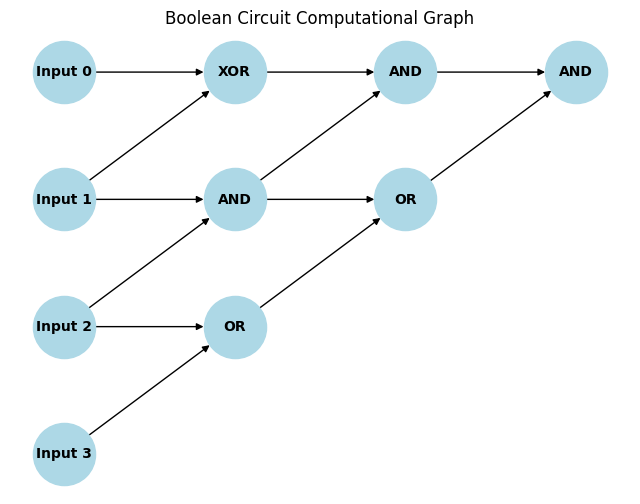

In [9]:
from matplotlib import pyplot as plt
from boolean_circuits.jax.utils.plotting import plot_circuit

fig, ax = plt.subplots(figsize=(8, 6))
plot_circuit(circuit, ax=ax)

Circuits can be called on an input to calculate the output of the circuit for a given input. 

The output of this call is a tuple of the final output and the intermediate outputs of each layer. Intermediate outputs are combined into a flat array ordered by layers and gates within layers, e.g.
```python
[gate for layer in circuit.layers for gate in layer.gates]
```
This array can be unflattened using the `circuit.unflatten_values()` method.

In [10]:
x = jnp.array([1,0,1,0])
output, intermediates = circuit(x)

print(f"Input: {x}")
print("Intermediates:")
intermediates_dict = circuit.unflatten_values(intermediates)
for layer, gate_dict in intermediates_dict.items():
    print(f" {layer}")
    for gate, values in gate_dict.items():
        print(f"   {gate}: {values}")
print(f"Output: {output}")

Input: [1 0 1 0]
Intermediates:
 layer_0
   gate_0: 1
   gate_1: 0
   gate_2: 1
 layer_1
   gate_0: 0
   gate_1: 1
Output: 0


### Input / Gate Influences

The *influence* of an input bit is defined as the probability that flipping that bit will change the output of the circuit:
$$
I[x_i] = \mathbb{P}[f(x) \neq f(x \oplus e_i)].
$$
This is a standard definition. Bits with a greater influence are more likely to change the output of the circuit.


Here we define the influence of a gate as the probability that flipping an input bit will change both the ouput of that gate and the output of the circuit. As far as I am aware this
is not a standard definition. The hope is that this definition of influences gives an approximate measure of how helpful it will be for a network to represent the computation performed by this gate.

An alternative definition would be the probability that flipping the gate output will change the circuit output (as with the definition of the influence of input bits). 
However this intervention-based definition does not reflect the sensitivity of the gate to the input. A gate which is not ever active within the context of the circuit (e.g. `AND(x, NOT(x))`) might still be assigned a high influence under this definition.

The influences of input bits and gates are calculated using the `circuit.calculate_influences()` method. They can also be added to the `plot_circuit` visulation using the `annotate_influences` flag.


Input influences: [0.25 0.25 0.25 0.  ]
Gate influences:
{
  "layer_0": {
    "gate_0": 0.125,
    "gate_1": 0.125,
    "gate_2": 0.03125
  },
  "layer_1": {
    "gate_0": 0.1875,
    "gate_1": 0.03125
  }
}


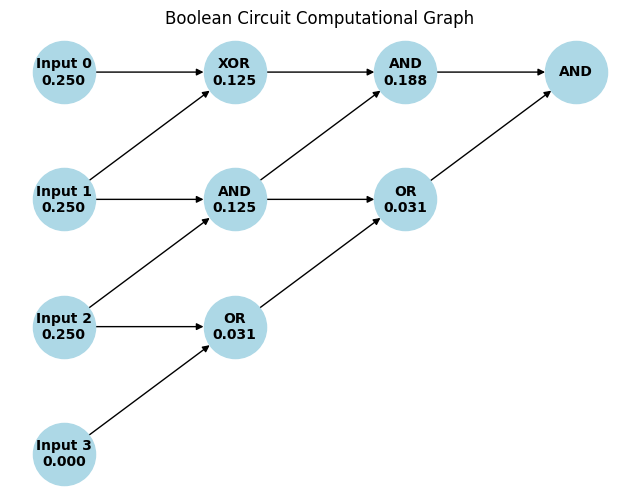

In [11]:
import jax
import json
from matplotlib import pyplot as plt

from boolean_circuits.jax.utils.plotting import plot_circuit

input_influences, gate_influences = circuit.calculate_influences()
print(f"Input influences: {input_influences}")

print("Gate influences:")
gate_infl_dict = circuit.unflatten_values(gate_influences)
gate_infl_dict = jax.tree.map(lambda x: x.tolist(), gate_infl_dict)
print(json.dumps(gate_infl_dict, indent=2))

fig, ax = plt.subplots(figsize=(8, 6))
plot_circuit(circuit, ax=ax, annotate_influence=True)